<a href="https://colab.research.google.com/github/CaloCare/MachineLearning/blob/main/CaloCare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**CaloCare**

## Importing Packages/Libraries

In [26]:
# Import necessary libraries
import os  # For file and directory operations
import matplotlib.pyplot as plt  # For plotting and visualizations
import matplotlib.image as mpimg  # For loading and displaying images

import shutil  # For moving and copying files
import random  # For generating random selections

from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For data augmentation
import numpy as np  # For numerical operations
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report  # For evaluation metrics

# Import Keras components for model building
from keras.applications import MobileNetV2  # Pre-trained model for transfer learning
from keras.models import Sequential  # Sequential model structure
from keras.layers import Dense, Dropout, Flatten  # Layers for building neural networks
from keras.optimizers import Adam  # Optimizer for compiling the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

**Insight:**

This code imports essential libraries and modules needed for data handling, visualization, model building, and evaluation. It includes utilities for file operations, image processing, and data augmentation, as well as components from Keras to build and train a neural network model using MobileNetV2 for transfer learning. The setup supports a streamlined workflow for preparing an image dataset, constructing a deep learning model, and evaluating its performance on classification tasks.

## Data Wrangling

In [27]:
!pip install kaggle

In [28]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [29]:
!cp kaggle.json ~/.kaggle

cp: cannot stat 'kaggle.json': No such file or directory


In [30]:
!chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [31]:
!kaggle datasets download -d 'faldoae/padangfood'

Dataset URL: https://www.kaggle.com/datasets/faldoae/padangfood
License(s): ODbL-1.0
padangfood.zip: Skipping, found more recently modified local copy (use --force to force download)


In [32]:
import zipfile

with zipfile.ZipFile('padangfood.zip', 'r') as zip_ref:
    zip_ref.extractall('padangfood')

**Insight:**

The code snippet sets up access to Kaggle datasets by installing the kaggle library and configuring the API credentials through a `kaggle.json` file. It creates a hidden `.kaggle` directory, copies the `kaggle.json` file containing the API key into this directory, and sets appropriate file permissions to ensure secure access. The code then uses the Kaggle API to download a dataset titled "Padang Food" by specifying its identifier `(faldoae/padangfood)`. After downloading, it extracts the contents of the `padangfood.zip` file into a directory named `padangfood`, making the dataset ready for use in further analysis or model training. This setup is useful for automating the process of accessing and preparing datasets from Kaggle.

### Assessing Data

Class: ayam_goreng - Sample Count: 107
-----------------------------------------------------


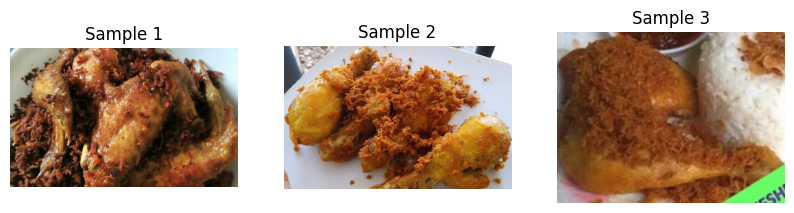



Class: test - Sample Count: 0
-----------------------------------------------------


<Figure size 1000x500 with 0 Axes>



Class: dendeng_batokok - Sample Count: 109
-----------------------------------------------------


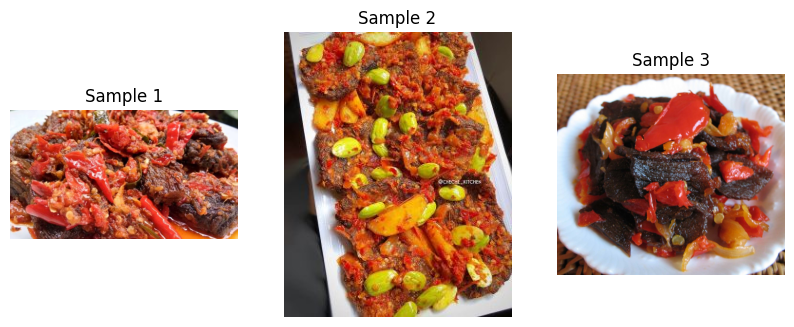



Class: train - Sample Count: 0
-----------------------------------------------------


<Figure size 1000x500 with 0 Axes>



Class: gulai_ikan - Sample Count: 111
-----------------------------------------------------


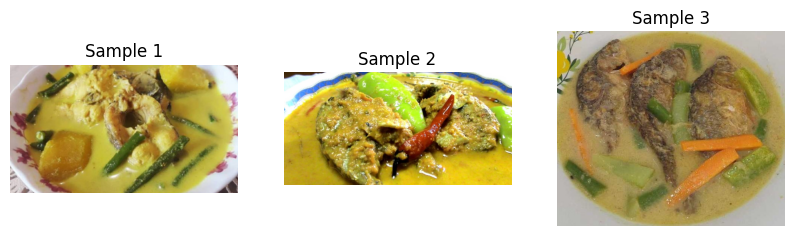



Class: telur_balado - Sample Count: 111
-----------------------------------------------------


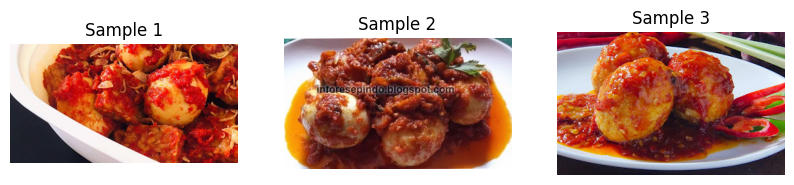



Class: ayam_pop - Sample Count: 113
-----------------------------------------------------


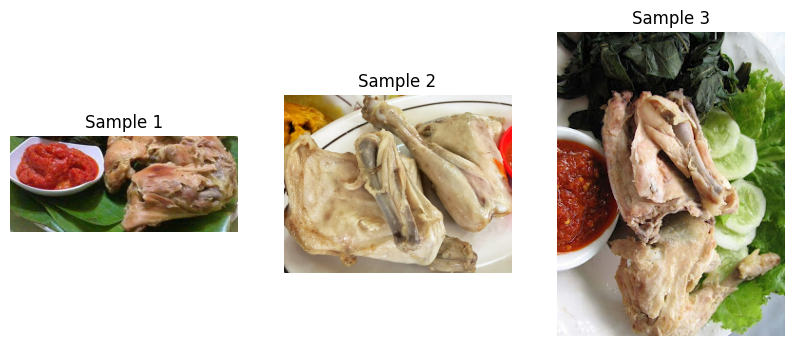



Class: gulai_tambusu - Sample Count: 103
-----------------------------------------------------


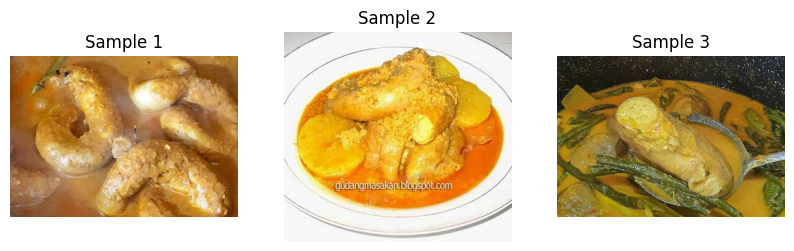



Class: telur_dadar - Sample Count: 116
-----------------------------------------------------


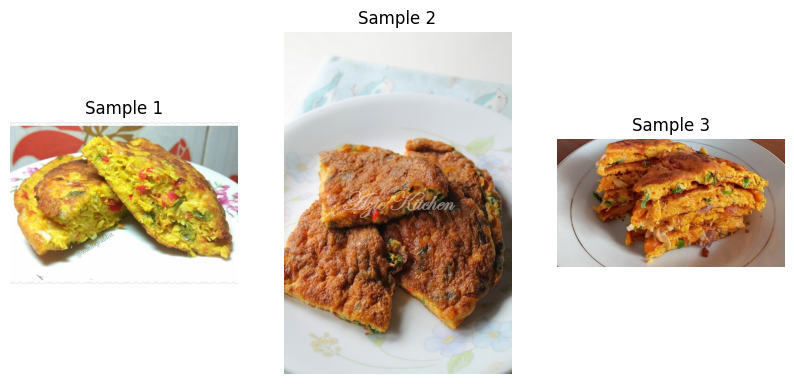



Class: val - Sample Count: 0
-----------------------------------------------------


<Figure size 1000x500 with 0 Axes>



Class: daging_rendang - Sample Count: 104
-----------------------------------------------------


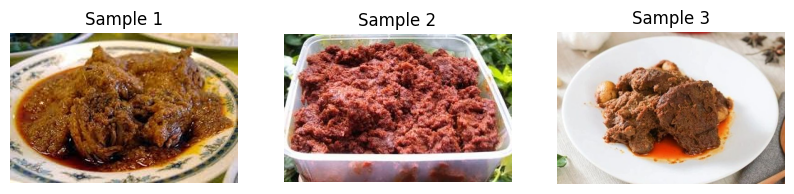



Class: gulai_tunjang - Sample Count: 119
-----------------------------------------------------


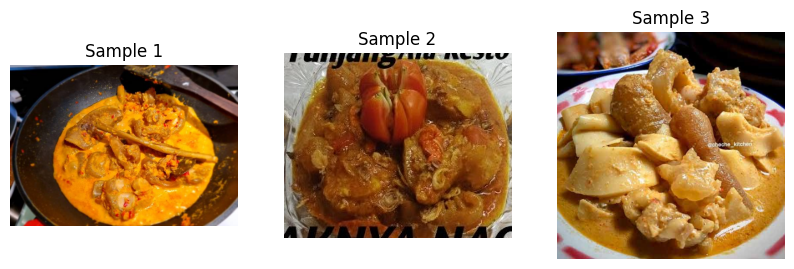

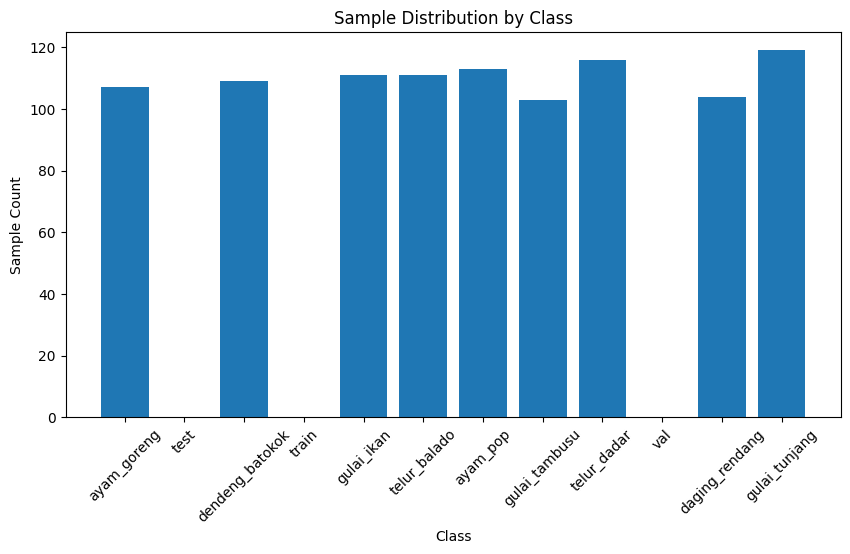

In [33]:
# Define the dataset folder location
dataset_folder = "/content/padangfood/dataset_padang_food"

# Create a dictionary to store the number of samples in each class
class_counts = {}

# Loop through each class in the dataset
for class_name in os.listdir(dataset_folder):
    class_folder = os.path.join(dataset_folder, class_name)

    # Ensure that only folders (not files) are processed in the loop
    if os.path.isdir(class_folder):
        # Count the number of images in each class
        num_images = len([f for f in os.listdir(class_folder) if os.path.isfile(os.path.join(class_folder, f))]) # only count files, not directories
        class_counts[class_name] = num_images

        # Display some sample images from each class
        print(f"Class: {class_name} - Sample Count: {num_images}")
        print("-----------------------------------------------------")
        plt.figure(figsize=(10, 5))
        for i, image_file in enumerate([f for f in os.listdir(class_folder) if os.path.isfile(os.path.join(class_folder, f))][:3]): # loop over files, not directories
            # Full path to the image
            image_path = os.path.join(class_folder, image_file)
            # Read and display the image using Matplotlib
            plt.subplot(1, 3, i + 1)
            image = mpimg.imread(image_path)
            plt.imshow(image)
            plt.title(f"Sample {i + 1}")
            plt.axis('off')  # Remove axes
        plt.show()
        print("\n")

# Display the sample distribution for each class
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Sample Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Sample Count')
plt.xticks(rotation=45)
plt.show()

**Insight:**

This code thoroughly examines the dataset structure and class distribution within a collection of Padang food images. By iterating over each class directory, it counts the number of samples per class, providing an overview of the dataset’s balance. Displaying three sample images per class allows for a quick visual check, ensuring that the images are appropriately labeled and representative of each category. The bar plot visualizing sample distribution across classes highlights any imbalances, which are essential to consider before model training. A balanced dataset, where each food category is equally represented, would enable the model to learn without bias toward any specific class. Conversely, if significant class imbalance is detected, techniques such as data augmentation or resampling may be necessary to improve the model’s generalization and ensure fair performance across all classes.

### Cleaning Data and Splitting

In [34]:
# Directory for the dataset
dataset_dir = "/content/padangfood/dataset_padang_food"

# List of each class name in the dataset
classes = ["ayam_goreng", "dendeng_batokok", "gulai_ikan", "telur_balado", "ayam_pop", "gulai_tambusu", "telur_dadar", "daging_rendang", "gulai_tunjang"]

# Ratios for train, validation, and test sets
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Loop through each class in the dataset
for class_name in classes:
    # Path to the current class directory
    class_dir = os.path.join(dataset_dir, class_name)

    # List all files in the current class directory
    files = os.listdir(class_dir)

    # Shuffle files randomly to ensure random distribution
    random.shuffle(files)

    # Calculate the number of files for each train, validation, and test set
    num_files = len(files)
    num_train = int(num_files * train_ratio)
    num_val = int(num_files * val_ratio)
    num_test = num_files - num_train - num_val

    # Split files into train, validation, and test sets
    train_files = files[:num_train]
    val_files = files[num_train:num_train + num_val]
    test_files = files[num_train + num_val:]

    # Create new directories for train, validation, and test sets
    for folder_name, file_list in [("train", train_files), ("val", val_files), ("test", test_files)]:
        folder_path = os.path.join(dataset_dir, folder_name, class_name)
        os.makedirs(folder_path, exist_ok=True)
        # Move files to the appropriate folder based on their set
        for file in file_list:
            src = os.path.join(class_dir, file)
            dst = os.path.join(folder_path, file)
            shutil.move(src, dst)

**Insight:**

The code above efficiently organizes the Padang food image dataset by splitting it into training, validation, and test sets, ensuring an `80-10-10 ratio` for each category. By iterating through each class folder, it randomly shuffles the images to ensure a balanced and unbiased distribution across the splits. For each class, it calculates the number of files required for training, validation, and testing, then moves the images into newly created directories corresponding to each split. This structured organization is crucial for machine learning workflows, as it prepares the dataset for effective model training and evaluation. By creating separate datasets, it ensures that the model is trained on a distinct set of images, validated on a different set to tune parameters, and finally tested on an unseen set to evaluate performance, thereby enhancing model generalization and reliability.

### Data Augmentation & Normalization

In [35]:
# Dataset directory
dataset_dir = "/content/padangfood/dataset_padang_food"

# Dimensions for each image
img_width, img_height = 256, 256

# Batch size for images
batch_size = 32

# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to range [0,1]
    horizontal_flip=True)  # Randomly flip images horizontally to augment data

val_datagen = ImageDataGenerator(rescale=1./255)  # Only normalize pixel values for validation set
test_datagen = ImageDataGenerator(rescale=1./255)  # Only normalize pixel values for test set

# Data generators for training, validation, and test sets
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(dataset_dir, 'train'),
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    directory=os.path.join(dataset_dir, 'val'),
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    directory=os.path.join(dataset_dir, 'test'),
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)  # Set shuffle to False for consistent evaluation

Found 950 images belonging to 9 classes.
Found 182 images belonging to 9 classes.
Found 202 images belonging to 9 classes.


**Insight:**

The code configures data preprocessing for the Padang food image dataset, including data augmentation for training and normalization for all sets (training, validation, and test). By resizing images to a standard dimension and normalizing pixel values, it ensures consistency in input data, enhancing model performance and stability during training. The horizontal flip applied to the training data introduces variability, helping the model generalize better by simulating diverse viewing angles. Separate data generators for each set also maintain the integrity of validation and test sets, preventing data leakage and enabling accurate performance assessment. This setup prepares the dataset effectively for robust model training and evaluation.

### Training Data and Model Building


In [45]:
# Load the pre-trained MobileNetV2 model without the top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Optionally freeze the layers of the base model to retain pre-trained weights during training
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the pre-trained base model
model = Sequential()
model.add(base_model)  # Add the base model as the first layer
model.add(Flatten())  # Flatten the output of the base model
model.add(Dense(128, kernel_regularizer=l2(0.01)))  # Add L2 regularization
model.add(BatchNormalization())  # Add Batch Normalization
model.add(Activation('relu'))  # Add ReLU activation
model.add(Dropout(0.6))  # Add dropout to reduce overfitting
model.add(Dense(9, activation='softmax'))  # Output layer with 9 classes using softmax activation

# Compile the model using the Adam optimizer and categorical crossentropy loss
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

<ipython-input-45-1dd018e9507d>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 355ms/step - accuracy: 0.3827 - loss: 4.4947 - val_accuracy: 0.6500 - val_loss: 3.6664
Epoch 2/50
 1/29 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.6562 - loss: 3.5493

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.6562 - loss: 3.5493 - val_accuracy: 0.7727 - val_loss: 3.4172
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - accuracy: 0.8414 - loss: 3.0408 - val_accuracy: 0.9062 - val_loss: 2.6999
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8125 - loss: 3.0852 - val_accuracy: 0.9545 - val_loss: 2.4686
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - accuracy: 0.9022 - loss: 2.7713 - val_accuracy: 0.9500 - val_loss: 2.4686
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9688 - loss: 2.5987 - val_accuracy: 1.0000 - val_loss: 2.3673
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - accuracy: 0.9458 - loss: 2.6146 - val_accuracy: 0.9688 - val_loss: 2.3455
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9688 - loss: 2.4684 - val_accuracy: 1.0000 - val_loss: 2.3277
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - accuracy: 0.9562 - loss: 2.4513 - val_accuracy: 0.9750 - val_loss:

**Insight:**

The code builds a custom classifier using MobileNetV2 as a base model, leveraging its pre-trained features for transfer learning, and adds fully connected layers tailored to a nine-class Padang food classification task. With dropout applied to reduce overfitting and an optimized learning rate, the model is trained to learn complex patterns in the data effectively while validating performance on a separate dataset. This approach combines efficiency and accuracy by reusing a robust pre-trained model and adapting it to a new, specialized classification task.

## Model Evaluation and Visualization

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - accuracy: 0.9704 - loss: 0.8797
Test accuracy: 0.9739583134651184


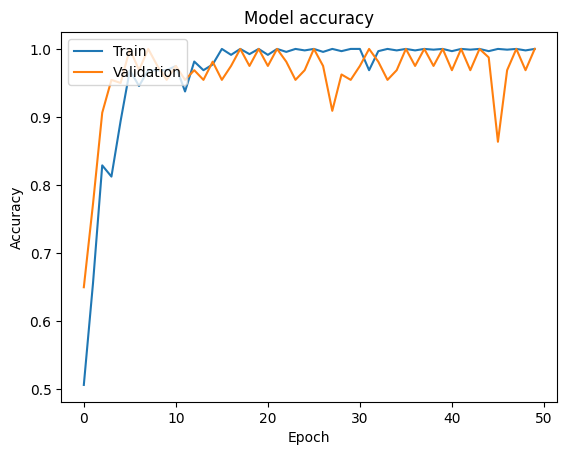

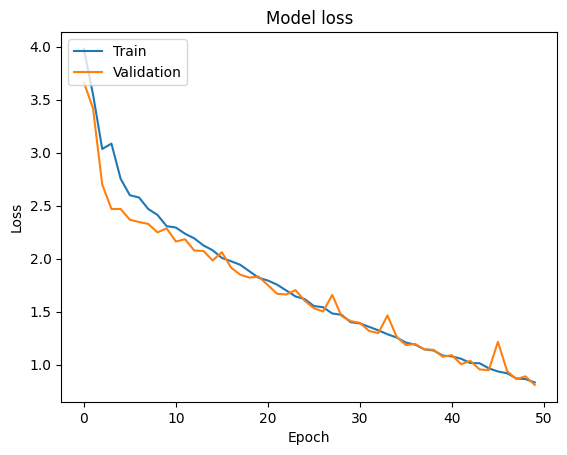

In [46]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Test accuracy:', test_acc)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 448ms/step


<Figure size 1600x1600 with 0 Axes>

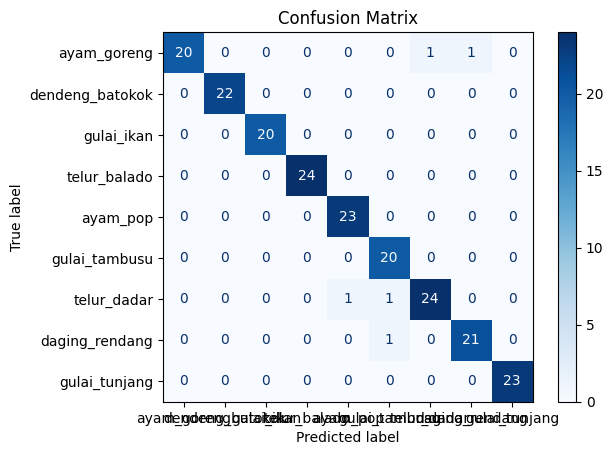

                 precision    recall  f1-score   support

    ayam_goreng       1.00      0.91      0.95        22
dendeng_batokok       1.00      1.00      1.00        22
     gulai_ikan       1.00      1.00      1.00        20
   telur_balado       1.00      1.00      1.00        24
       ayam_pop       0.96      1.00      0.98        23
  gulai_tambusu       0.91      1.00      0.95        20
    telur_dadar       0.96      0.92      0.94        26
 daging_rendang       0.95      0.95      0.95        22
  gulai_tunjang       1.00      1.00      1.00        23

       accuracy                           0.98       202
      macro avg       0.98      0.98      0.98       202
   weighted avg       0.98      0.98      0.98       202



In [47]:
# Get predicted classes from the model on the test dataset
y_pred = np.argmax(model.predict(test_generator), axis=1)

# Get the true labels from the test dataset
y_true = test_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# List of each class name
classes = ["ayam_goreng", "dendeng_batokok", "gulai_ikan", "telur_balado", "ayam_pop", "gulai_tambusu", "telur_dadar", "daging_rendang", "gulai_tunjang"]

# Display the confusion matrix
plt.figure(figsize=(16, 16))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Calculate and display the classification report (precision, recall, F1-score)
report = classification_report(y_true, y_pred, target_names=classes)
print(report)

Saving ayamgoreng.jpeg to ayamgoreng (5).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


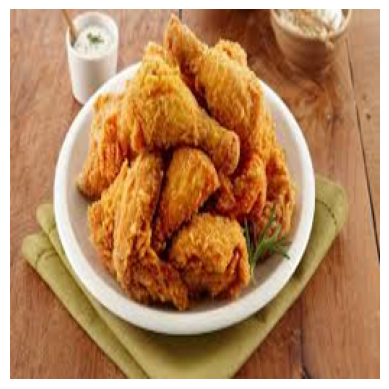

Prediksi Kelas: gulai_tambusu


In [49]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image

# Mendapatkan mapping indeks ke nama kelas
class_indices = train_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}  # Membalik dictionary

# Fungsi untuk mengunggah dan memuat gambar
uploaded = files.upload()

for file_name in uploaded.keys():
    # Memuat gambar dari file yang diunggah
    img = Image.open(file_name)
    img = img.resize((img_width, img_height))  # Ubah ukuran gambar sesuai input model
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalisasi gambar

    # Membuat prediksi
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)

    # Menampilkan gambar dan hasil prediksi
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print("Prediksi Kelas:", class_names[predicted_class[0]])


## Conclusion

- Conclution pertanyaan 1
- Conclution pertanyaan 2